# Inspired from work by Jencka and Adams

In [14]:
import pandas as pd
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe

In [2]:
header = ("X", "Y", "Z", "TIME", "SLURM_NNODES", "SLURM_NTASKS_PER_NODE", "OMP_NUM_THREADS", "SLURM_GPUS_PER_NODE", "GFLOPS")

In [3]:
dat_hopper = pd.read_csv('global_results.csv', names=header)
dat_hopper['Cluster'] = 'Hopper'

In [5]:
data = pd.concat((dat_hopper,))
data

,X,Y,Z,TIME,SLURM_NNODES,SLURM_NTASKS_PER_NODE,OMP_NUM_THREADS,SLURM_GPUS_PER_NODE,GFLOPS,Cluster
0,8,24,56,300,1,1,1,0,2.11761,Hopper
1,24,8,8,300,1,1,1,0,2.23081,Hopper
2,8,24,8,300,1,1,1,0,2.22611,Hopper
3,24,8,32,300,1,1,1,0,2.27926,Hopper
4,8,8,32,300,1,1,1,0,2.28929,Hopper
...,...,...,...,...,...,...,...,...,...,...
1180,168,136,80,300,1,4,1,0,1.26283,Hopper
1181,168,152,32,300,1,4,1,0,1.06409,Hopper
1182,168,152,56,300,1,4,1,0,1.23025,Hopper
1183,168,168,32,300,1,4,1,0,1.11016,Hopper


In [7]:
data['Process Count'] = data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'] * data['OMP_NUM_THREADS']

In [12]:
data['Problem Size'] = data['X'] * data['Y'] * data['Z']

# Plots

In [15]:
def label_peaks(df, groupby, value, troughs=False):
    mean = df.groupby(groupby).mean(numeric_only=True)[value]
    idx, _ = signal.find_peaks(mean)
    peaks = mean.iloc[idx]

    if troughs:
        idx, _ = signal.find_peaks(-mean)
        peaks = pd.concat((peaks, mean.iloc[idx]))

    for (x, y) in peaks.items():
        plt.text(x, y, str(x), path_effects=[pe.withStroke(linewidth=4, foreground="white")])

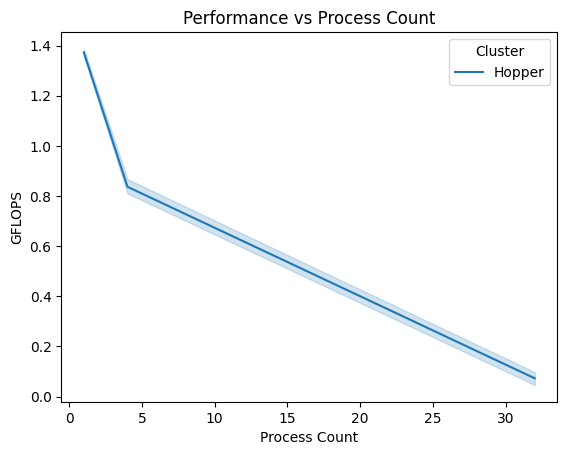

In [10]:
sns.lineplot(data, x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count.svg')

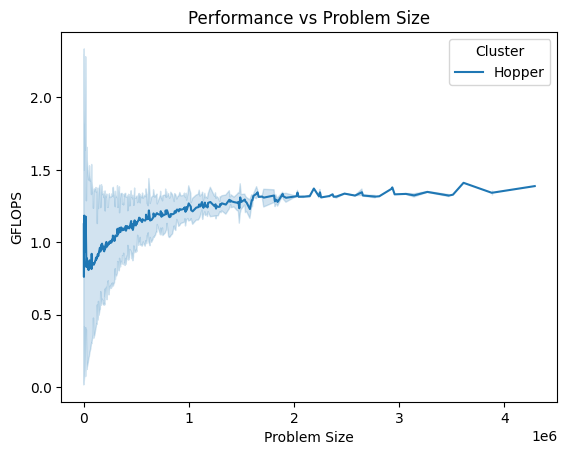

In [17]:
sns.lineplot(data, x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Problem Size')
plt.savefig('figures/flops_problem_size.svg')

# Statistics

In [18]:
# Summary Stats for performance of ALL runs
stats_all_runs = data["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_all_runs

count    1185.000000
mean        1.118010
std         0.379580
min         0.015882
25%         0.955497
50%         1.303760
75%         1.328670
90%         1.357716
95%         1.413132
99%         2.244126
max         2.468000
Name: GFLOPS, dtype: float64

In [19]:
# Summary stats for Hopper
stats_hopper = data[data['Cluster'] == 'Hopper']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper

count    1185.000000
mean        1.118010
std         0.379580
min         0.015882
25%         0.955497
50%         1.303760
75%         1.328670
90%         1.357716
95%         1.413132
99%         2.244126
max         2.468000
Name: GFLOPS, dtype: float64

In [22]:
# latex
print(pd.concat([stats_all_runs,], axis=1).to_latex())

\begin{tabular}{lr}
\toprule
{} &       GFLOPS \\
\midrule
count &  1185.000000 \\
mean  &     1.118010 \\
std   &     0.379580 \\
min   &     0.015882 \\
25\%   &     0.955497 \\
50\%   &     1.303760 \\
75\%   &     1.328670 \\
90\%   &     1.357716 \\
95\%   &     1.413132 \\
99\%   &     2.244126 \\
max   &     2.468000 \\
\bottomrule
\end{tabular}

